# Import and Cleaning

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime
from functions import remove_high_corr, scale_variables, best_params_grid,\
    calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label,get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split,\
    cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,\
    make_scorer, balanced_accuracy_score, f1_score, matthews_corrcoef

# Load data

In [2]:
data = pd.read_csv("/home/gustavo/github/mestrado/reworks/models/oral_vs_non_oral/data/fda_rdkit_preprocessed.csv")
data.drop(columns='Unnamed: 0', inplace=True)
data.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Separating X and Y matrices, and Test and Train

In [3]:
Y = data['oral']
#Transforming oral into two categories
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: oral, dtype: float64

In [4]:
X = data.iloc[:, 14:]
X.head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.055556,-0.333333,0.333333,0.242956,59.072,0.0,0.182528,-0.370334,1.50,14.880242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.451389,-0.439815,0.439815,0.301333,75.067,0.0,0.239711,-0.288644,2.00,16.466627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.229167,-0.939815,0.939815,0.256644,76.055,0.0,0.335391,-0.349891,2.00,16.470004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.951389,0.683642,0.683642,0.419021,77.152,0.0,0.002549,-0.329661,1.75,32.116866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.555556,-0.611111,0.611111,0.373753,78.136,0.0,0.094572,-0.616764,1.50,32.227566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
np.random.seed(6752)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Scaling datasets

In [6]:
# Train
x_train_scaled = scale_variables(x_train)
# Adding a constant to represent the intercept term
x_train_scaled = sm.add_constant(x_train_scaled)
x_train_scaled.head()

,const,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,-0.154108,0.814976,-0.721525,0.811021,-1.052512,0.0,-0.398389,0.964659,0.686968,...,-0.172169,-0.257509,-0.249595,-0.106714,-0.106714,-0.125401,-0.157288,-0.140368,-0.198281,-0.190158
1,1.0,0.459209,-0.178832,-0.712059,-1.701550,0.385910,0.0,0.577007,-0.705735,-0.821249,...,-0.172169,-0.257509,-0.249595,-0.106714,-0.106714,-0.125401,-0.157288,-0.140368,0.807996,4.722828
2,1.0,-0.415895,0.394953,0.059087,-0.939674,0.174803,0.0,-0.959085,-0.856191,-1.100102,...,-0.172169,-0.257509,-0.249595,-0.106714,-0.106714,-0.125401,-0.157288,-0.140368,0.807996,-0.190158
3,1.0,0.340410,0.737281,-0.282616,1.388328,-0.649089,0.0,-0.044006,1.397864,0.250590,...,-0.172169,-0.257509,-0.249595,-0.106714,-0.106714,-0.125401,-0.157288,-0.140368,-0.198281,-0.190158
4,1.0,0.264525,0.792540,-0.594782,0.030336,0.322057,0.0,-0.353521,-0.848359,-0.686452,...,-0.172169,-0.257509,-0.249595,-0.106714,-0.106714,-0.125401,-0.157288,-0.140368,-0.198281,-0.190158


In [7]:
# Test
x_test_scaled = scale_variables(x_test)
x_test_scaled = sm.add_constant(x_test_scaled)
x_test_scaled.head()

,const,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,0.535562,-1.677981,-0.766240,-1.371818,0.964475,-0.04598,-0.306140,-0.822125,-0.374982,...,-0.177261,-0.228477,-0.249461,7.187953,-0.122431,-0.079809,-0.116991,-0.141527,-0.186243,-0.251154
1,1.0,0.473418,-1.969351,-0.601374,0.315758,0.021522,-0.04598,-0.091577,0.483025,1.709014,...,-0.177261,-0.228477,5.973928,-0.139122,-0.122431,-0.079809,-0.116991,5.956986,0.472558,-0.251154
2,1.0,0.224063,0.389131,0.658994,1.137308,-0.449281,-0.04598,0.551436,-0.426433,-0.204935,...,-0.177261,-0.228477,-0.249461,-0.139122,-0.122431,-0.079809,-0.116991,-0.141527,-0.186243,3.717076
3,1.0,0.136791,0.160610,-0.564519,0.786779,-0.362201,-0.04598,-0.974184,0.578437,0.356958,...,-0.177261,-0.228477,-0.249461,-0.139122,8.167881,-0.079809,-0.116991,-0.141527,-0.186243,-0.251154
4,1.0,-0.355161,-0.029433,-0.238802,-0.268752,-1.222457,-0.04598,0.692629,-1.049503,1.410509,...,-0.177261,-0.228477,-0.249461,-0.139122,-0.122431,-0.079809,-0.116991,-0.141527,-0.186243,-0.251154


In [8]:
# Creating a dataframe to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name",
        "cv_test_auc",
        "training_mis_rate",
        "test_mis_rate",
        "training_auc",
        "test_auc",
        "balanced_acc_test",
        "mcc_train",
        "mcc_test"
    ]
)

# Logistic Regression

## CV

In [9]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=500),
        'params': {}
    }
}

In [10]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train_scaled, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 16:48
Finished Grid Search for Logistic Regression: 16:48
Tempo de execução:  0.0 minutos


In [11]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.664873,{}


## Fitting Logistic

In [12]:
lr_params = gs_result_lr.iloc[0,2]
lr_params

{}

In [13]:
logistic = LogisticRegression(**lr_params, max_iter=500).fit(x_train_scaled, y_train)

## Get Training Error and AUC

In [14]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model = logistic,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.2555
Training AUC: 0.7026


## Make predicitons

In [15]:
y_predict_lr_label = logistic.predict(x_test_scaled)
y_predict_lr_prob = logistic.predict_proba(x_test_scaled)[:, 1]

## Test error and ROC

In [16]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_lr_label
)

Misclassification rate: 0.3418


Text(0.5, 1.0, 'Confusion Matrix: Logistic Regression\nOral vs Non Oral')

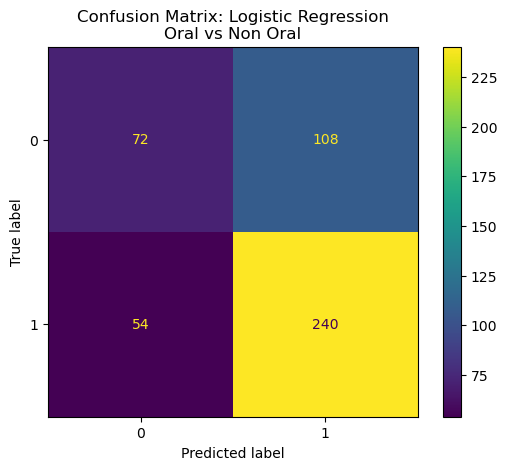

In [17]:
disp.plot()
plt.title(f"Confusion Matrix: Logistic Regression\nOral vs Non Oral")

## ROC/AUC

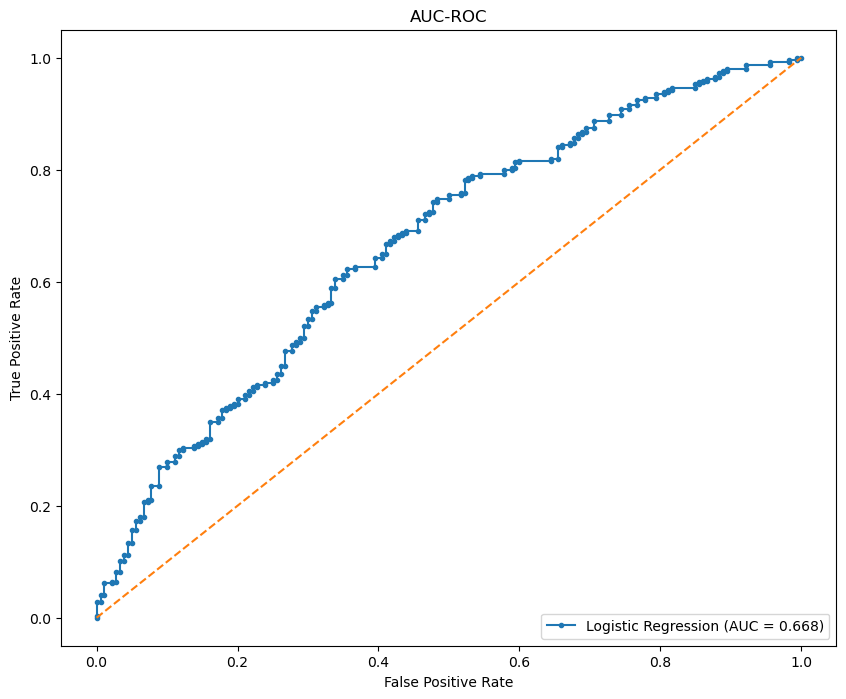

In [18]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name="Logistic Regression",
    title=f"AUC-ROC",
    save_path=f'/home/gustavo/github/mestrado/reworks/imgs/logistic_rdkit_total.png'
)

## Feature Imporance

In [19]:
print(logistic.coef_, logistic.intercept_)

[[ 6.28252679e-03  1.02071677e-01 -7.78104257e-02 -5.30462442e-02
   2.50683775e-01  4.52330237e-01  0.00000000e+00 -2.11738601e-02
   1.62553792e-01 -7.74401819e-02 -3.24675027e-01 -2.48091207e-01
   3.91717989e-01  3.56825834e-01 -2.03781728e-01 -6.98173171e-01
   2.59663526e-01 -2.19414173e-01 -9.93664674e-02 -6.24197658e-01
  -8.18048050e-02  9.65806926e-02 -4.95887718e-03  8.92337859e-02
  -7.85899923e-02 -1.84248234e-01 -8.93356452e-02 -2.26532425e-01
   1.00377049e-01 -2.20435587e-01 -7.02734715e-02  1.20499248e-02
  -8.77801319e-02 -2.16806227e-01 -1.26370529e-01 -1.24025787e-01
  -9.97980126e-01  7.02473516e-03  7.33271024e-02  5.62504226e-01
   3.68680990e-01 -3.36606841e-01  4.88049451e-01 -2.31517535e-01
   3.39057725e-02 -6.29818477e-01  1.02899226e-01  5.16861815e-01
   3.84881595e-01 -3.87429264e-01  4.25540239e-01 -1.33609233e-01
   8.24100748e-01  2.19060014e-01  3.77034142e-01  3.02640975e-01
   5.92952630e-01 -5.03177770e-01 -2.34350711e-01 -3.31922083e-02
   6.89397

## Results

In [20]:
balanced_acc_test_lr = balanced_accuracy_score(y_test, y_predict_lr_label)
mcc_test_lr = matthews_corrcoef(y_test, y_predict_lr_label)
mcc_train_lr = matthews_corrcoef(y_train, logistic.predict(x_train_scaled))

print( f"Balanced ACC test set {balanced_acc_test_lr}, \n\
       \nand MCC test set: {mcc_test_lr} \n and MCC train set {mcc_train_lr}")

Balanced ACC test set 0.6081632653061224, 
       
and MCC test set: 0.23765382493171613 
 and MCC train set 0.43866260209335617


In [21]:
final_results.loc[len(final_results.index)] = [
    "logistic",
    gs_result_lr['best_score'][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr,
    balanced_acc_test_lr,
    mcc_train_lr,
    mcc_test_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,logistic,0.664873,0.255454,0.341772,0.702582,0.667838,0.608163,0.438663,0.237654


# Decision Tree

## Hyperparameter Fine Tuning

In [23]:
model_params = {
    'Decision Tree':{
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [4,8,10,12,16],
            'ccp_alpha': [0,0.0001, 0.0003, 0.001,0.01]
        }
    }
}

In [24]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Decision Tree: 16:50
Finished Grid Search for Decision Tree: 16:51
Tempo de execução:  0.6 minutos


In [25]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.623333,"{'ccp_alpha': 0.001, 'criterion': 'entropy', '..."


## Fitting tree

In [26]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 10}

In [27]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train_scaled, y_train)

## Training Error and AUC

In [28]:
misr_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.1787
Training AUC: 0.7712


## Predictions

In [29]:
y_predict_dt_label = decision_tree.predict(x_test_scaled)
y_predict_dt_prob = decision_tree.predict_proba(x_test_scaled)[:,1]

## Test errors

In [30]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_dt_label
)

Misclassification rate: 0.3713


Text(0.5, 1.0, 'CM DecisionTree\nOral vs Non Oral')

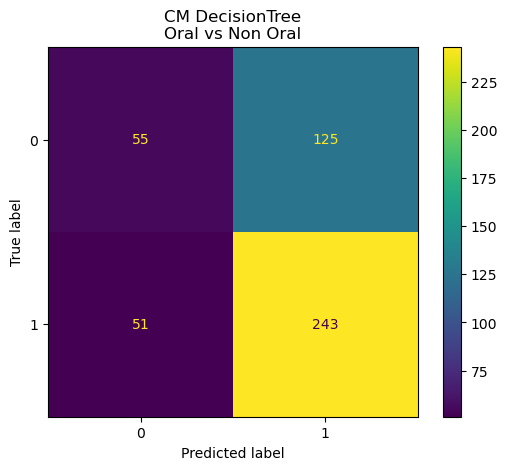

In [31]:
disp.plot()
plt.title(f"CM DecisionTree\nOral vs Non Oral")

## ROC AUC Test

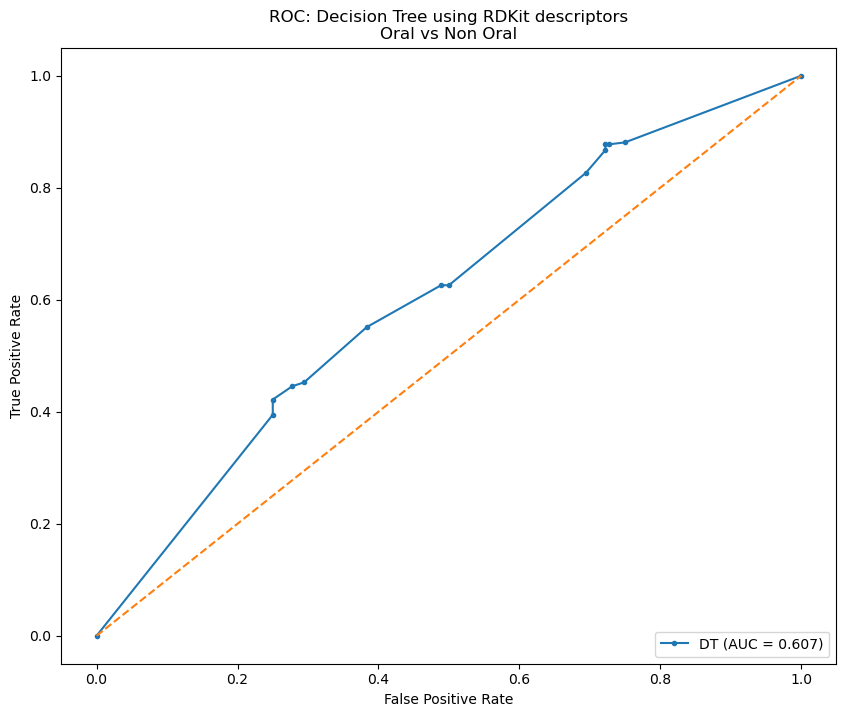

In [32]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name='DT',
    title=f"ROC: Decision Tree using RDKit descriptors\nOral vs Non Oral",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/dt_rdkit_total.png"
)

## Feature Importance

Text(0.5, 1.0, 'Feature Importance: Decision Trees\nOral vs Non Oral, RDKit Descriptors')

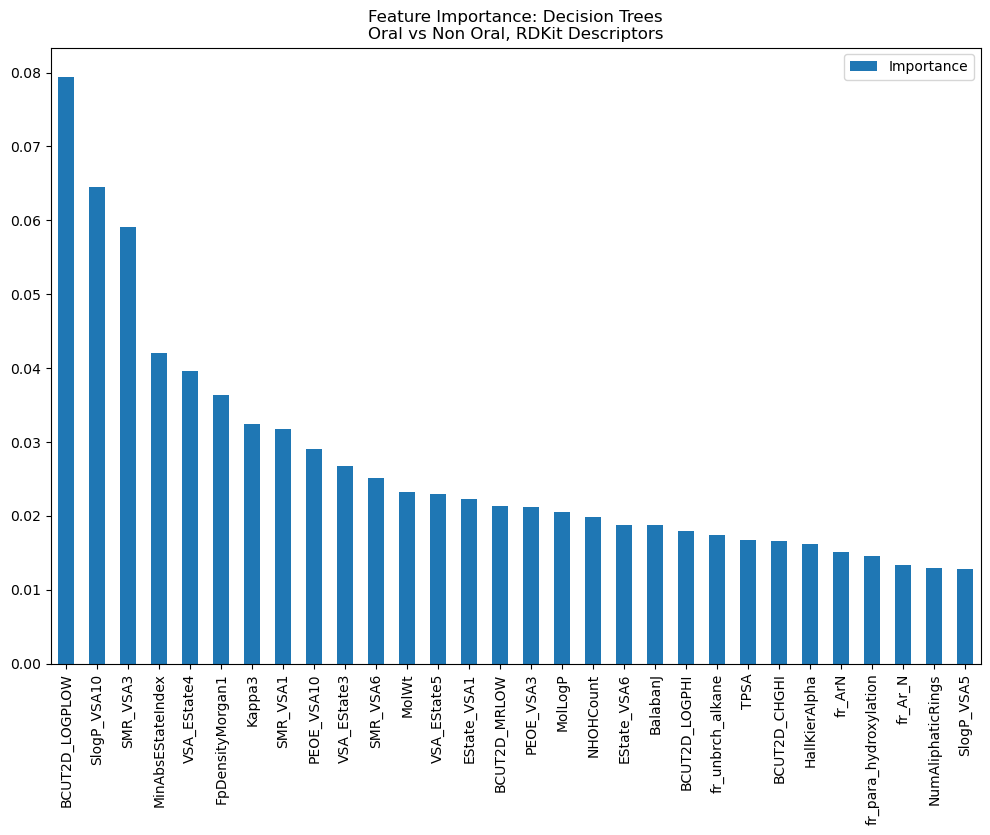

In [33]:
# print the feature importances
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(
    decision_tree.feature_importances_, 
    index=x_train_scaled.columns, 
    columns=['Importance'])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30, :].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance: Decision Trees\nOral vs Non Oral, RDKit Descriptors")


In [34]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance", 
                                                                                      ascending=False)
important_features_dt[0:30]

,Importance
BCUT2D_LOGPLOW,0.079414
SlogP_VSA10,0.064571
SMR_VSA3,0.059119
MinAbsEStateIndex,0.042042
VSA_EState4,0.039610
FpDensityMorgan1,0.036334
Kappa3,0.032422
SMR_VSA1,0.031681
PEOE_VSA10,0.028985
VSA_EState3,0.026705


## Results

In [35]:
balanced_acc_test_dt = balanced_accuracy_score(y_test, y_predict_dt_label)
mcc_train_dt = matthews_corrcoef(y_train, decision_tree.predict(x_train_scaled))
mcc_test_dt = matthews_corrcoef(y_test, y_predict_dt_label)

print( f"Balanced ACC test set: \
      {balanced_acc_test_dt} \nMCC train {mcc_train_dt}, \nMCC test {mcc_test_dt}")


final_results.loc[len(final_results.index)] = [
    "Decision Tree",
    gs_result_dt["best_score"][0],
    misr_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt,
    balanced_acc_test_dt,
    mcc_train_dt,
    mcc_test_dt
]
final_results

Balanced ACC tets set:       0.5660430839002268 
MCC train 0.6270756252727616, 
MCC test 0.15384749029418973


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,logistic,0.664873,0.255454,0.341772,0.702582,0.667838,0.608163,0.438663,0.237654
1,Decision Tree,0.623333,0.178747,0.371308,0.771203,0.606774,0.566043,0.627076,0.153847


# Random Forest and Bagging

Training Misclassification Rate: 0.1816
Training AUC: 0.7689
Misclassification rate: 0.2954


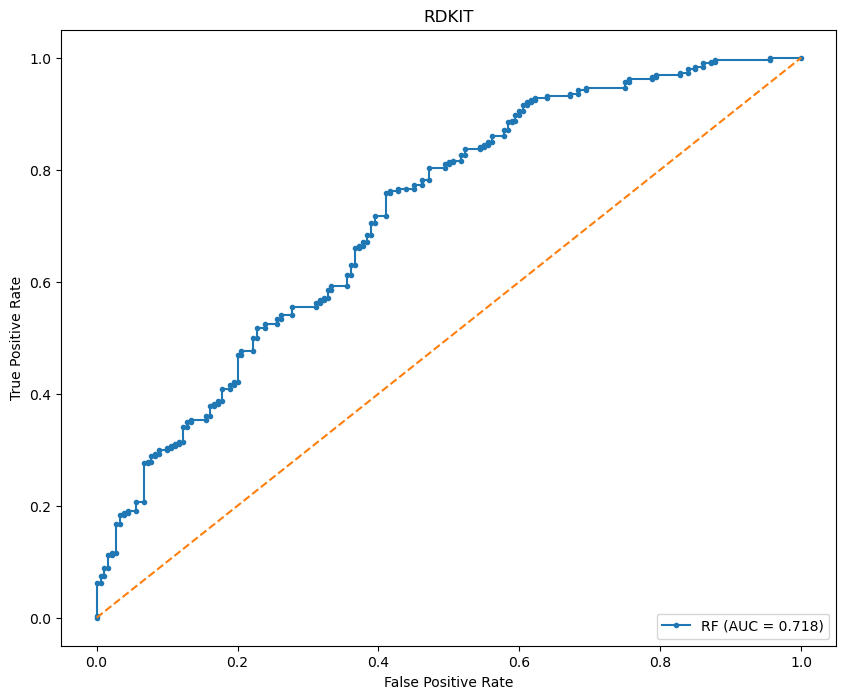

In [37]:
# Testing
rf_model_params_test = {'max_depth':10, 'ccp_alpha':0.003, 'min_samples_split':8,}
rf_test = RandomForestClassifier(**rf_model_params_test).fit(x_train_scaled, y_train)

#make predictions
y_predict_rf_label_test = rf_test.predict(x_test_scaled)
y_predict_rf_prob_test = rf_test.predict_proba(x_test_scaled)[:,1]

mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=rf_test,
    x=x_train_scaled,
    y_true=y_train
)
# test error
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_rf_label_test
)

auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob_test,
    model_name='RF',
    title=f'RDKIT',
    save_path='/home/gustavo/github/mestrado/reworks/imgs/random_forest_test.png'
)

In [38]:
# Hyperparameter finetuning

rf_model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'max_depth': [5, 11],
            'max_features': ['sqrt', x_train.shape[0]],
            'ccp_alpha': [0.002, 0.003],
            'min_samples_split':[4,10],
        }
    }
}

In [39]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train_scaled, y_train, rf_model_params)

Starting Grid Search for Random Forest: 17:00
Finished Grid Search for Random Forest: 17:05
Tempo de execução:  4.9 minutos


In [40]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.716736,"{'ccp_alpha': 0.002, 'max_depth': 11, 'max_fea..."


## Fitting Model

In [41]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0.002,
 'max_depth': 11,
 'max_features': 'sqrt',
 'min_samples_split': 4}

In [42]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train_scaled, y_train)

## Make Predictions

In [43]:
y_predict_rf_label = random_forest.predict(x_test_scaled)
y_predict_rf_prob = random_forest.predict_proba(x_test_scaled)[:,1]

## Get Training Error and AUC

In [44]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest,
    x=x_train_scaled,
    y_true=y_train,
)

Training Misclassification Rate: 0.1217
Training AUC: 0.8418


## Test error

In [45]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.3080


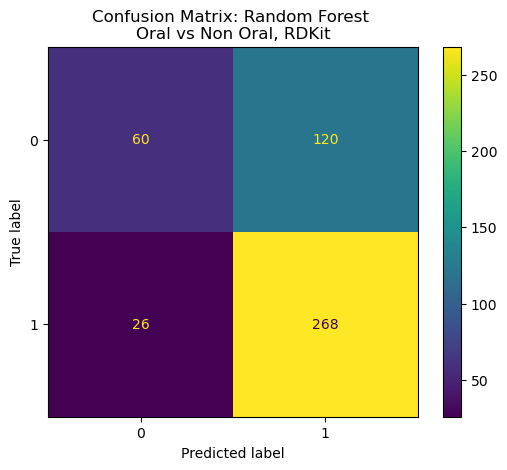

In [46]:
disp.plot()
plt.title(f"Confusion Matrix: Random Forest \nOral vs Non Oral, RDKit")
plt.show()

## ROC/AUC

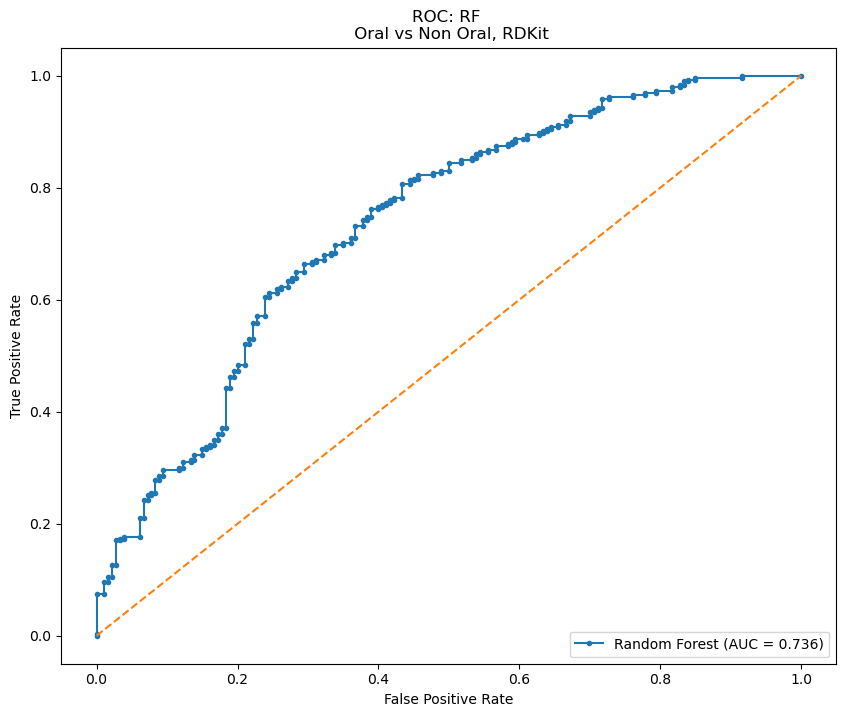

In [47]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name='Random Forest',
    title=f"ROC: RF \n Oral vs Non Oral, RDKit",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/roc_auc_rdkit_rf.png"
)

## Feature Importance

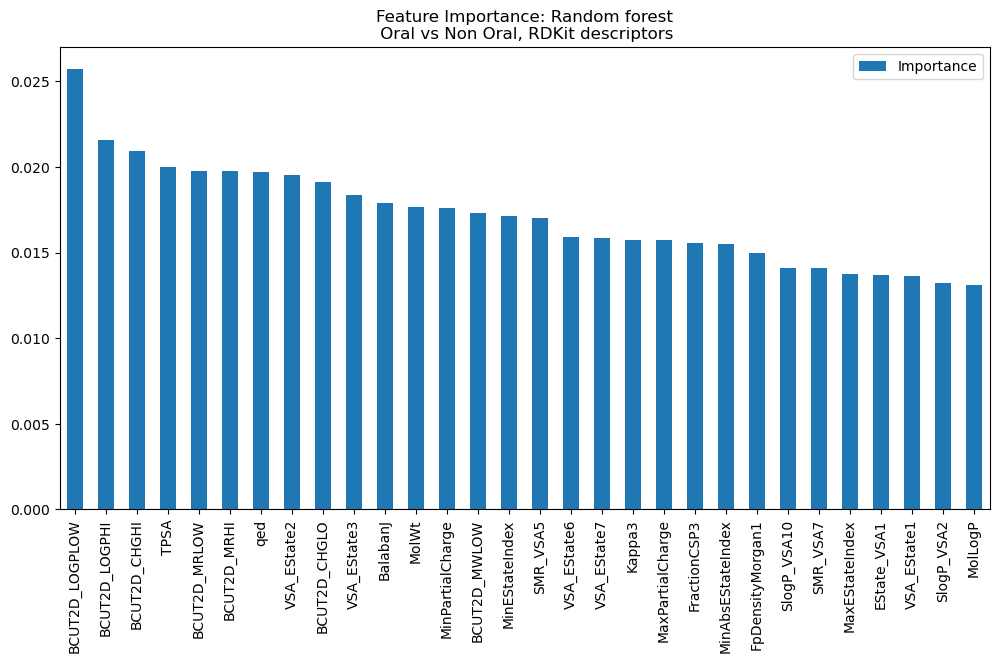

In [49]:
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(random_forest.feature_importances_, 
                                index=x_train_scaled.columns,
                                columns=['Importance'])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12,6), ax=ax)
ax.set_title(f"Feature Importance: Random Forest\n Oral vs Non Oral, RDKit descriptors")
fig.savefig(f"/home/gustavo/github/mestrado/reworks/imgs/feature_importance_rf_rdkit.png", dpi=300)

In [50]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance", ascending=False)
important_features_rf[0:30]

,Importance
BCUT2D_LOGPLOW,0.025696
BCUT2D_LOGPHI,0.021587
BCUT2D_CHGHI,0.020941
TPSA,0.020001
BCUT2D_MRLOW,0.019791
BCUT2D_MRHI,0.019737
qed,0.019712
VSA_EState2,0.019531
BCUT2D_CHGLO,0.019107
VSA_EState3,0.018347


## Saving Results

In [51]:
balanced_acc_test_rf = balanced_accuracy_score(y_test, y_predict_rf_label)
mcc_train_rf = matthews_corrcoef(y_train,random_forest.predict(x_train_scaled))
mcc_test_rf = matthews_corrcoef(y_test, y_predict_rf_label)

print( f"Balanced ACC test set {balanced_acc_test_rf}, MCC train set: {mcc_train_rf}, MCC test set: {mcc_test_rf}")

final_results.loc[len(final_results.index)] =[
    'Random Forest',
    gs_result_rf['best_score'][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf,
    balanced_acc_test_rf,
    mcc_train_rf,
    mcc_test_rf
]

final_results

Balanced ACC test set 0.6224489795918368, MCC train set: 0.749670997418247, MCC test set: 0.30841109647677245


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,logistic,0.664873,0.255454,0.341772,0.702582,0.667838,0.608163,0.438663,0.237654
1,Decision Tree,0.623333,0.178747,0.371308,0.771203,0.606774,0.566043,0.627076,0.153847
2,Random Forest,0.716736,0.121745,0.308017,0.841761,0.735544,0.622449,0.749671,0.308411


# Gradient Boosting

Training Misclassification Rate: 0.1379
Training AUC: 0.8186
Misclassification rate: 0.3080


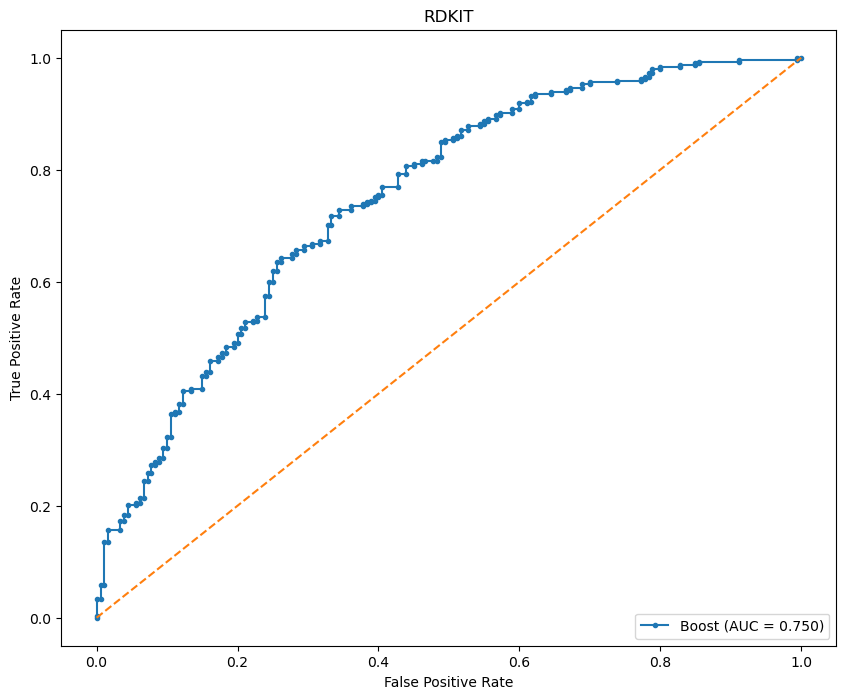

In [63]:
# Testing
gradient_boost_test_params = {'max_depth':10, 
                              'min_samples_split':10, 
                              'max_features':'sqrt', 
                              'learning_rate':0.011,
                              'subsample': 0.6}
boost_test = GradientBoostingClassifier(**gradient_boost_test_params).fit(x_train_scaled, y_train)

#make predictions
y_predict_boost_label_test = boost_test.predict(x_test_scaled)
y_predict_boost_prob_test = boost_test.predict_proba(x_test_scaled)[:,1]

mis_rate_boost_train, auc_boost_train = get_error_and_auc(
    model=boost_test,
    x=x_train_scaled,
    y_true=y_train
)
# test error
mis_rate_boost_test, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_boost_label_test
)

auc_boost = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boost_prob_test,
    model_name='Boost',
    title=f'RDKIT',
    save_path='/home/gustavo/github/mestrado/reworks/imgs/boost_test.png'
)

In [64]:
boosting_model_params = {
    'Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate': [0.008,0.011],
            'max_depth': [9,10,11],
            'min_samples_split':[10],
            'subsample':[0.6]
        }
    }
}

In [65]:
gs_result_boost, gs_result_boost_full = best_params_grid(x_train_scaled, y_train, boosting_model_params)

Starting Grid Search for Boosting: 17:29
Finished Grid Search for Boosting: 17:33
Tempo de execução:  3.7 minutos


In [66]:
gs_result_boost

,model,best_score,best_params
0,Boosting,0.719951,"{'learning_rate': 0.008, 'max_depth': 10, 'min..."


## Fitting the Model

In [67]:
boosting_params = gs_result_boost.iloc[0,2]
boosting_params

{'learning_rate': 0.008,
 'max_depth': 10,
 'min_samples_split': 10,
 'subsample': 0.6}

In [68]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train_scaled,y_train)

## Get training error and AUC

In [69]:
mis_rate_boost_train, auc_boost_train = get_error_and_auc(
    model=boosting,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.0880
Training AUC: 0.8838


## Make predictions

In [70]:
y_predict_boost_label = boosting.predict(x_test_scaled)
y_predict_boost_prob = boosting.predict_proba(x_test_scaled)[:,1]

## Test error

In [71]:
mis_rate_bost, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_boost_label
)

Misclassification rate: 0.3122


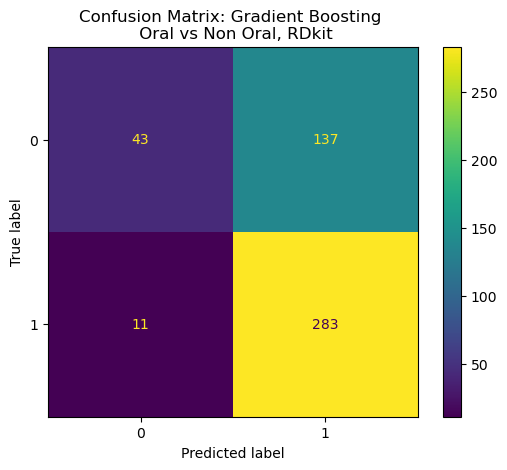

In [72]:
disp.plot()
plt.title(f"Confusion Matrix: Gradient Boosting \n Oral vs Non Oral, RDkit")
plt.show()

## ROC/AUC

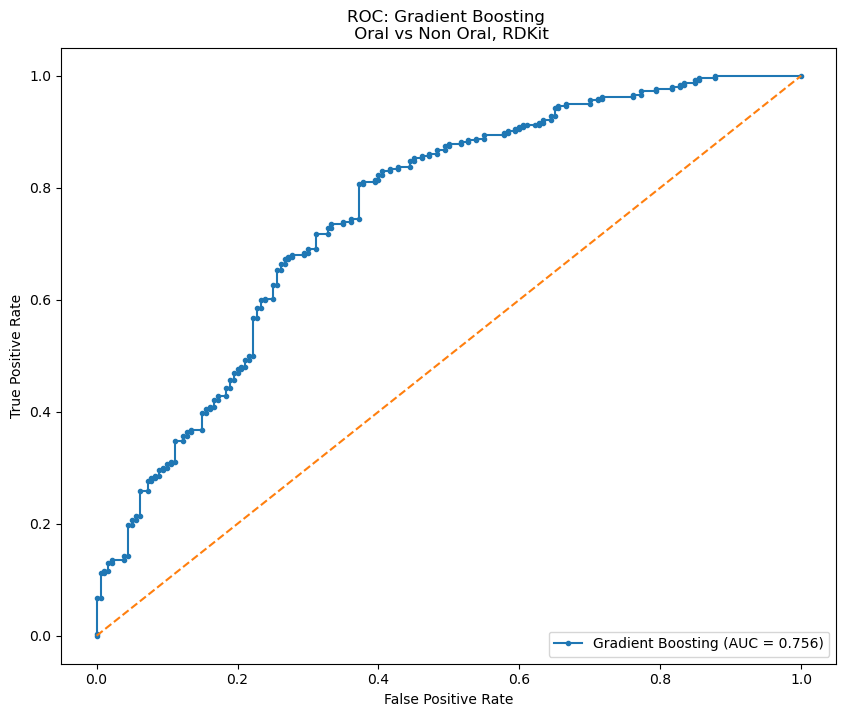

In [73]:
auc_boost = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boost_prob,
    model_name='Gradient Boosting',
    title=f"ROC: Gradient Boosting \n Oral vs Non Oral, RDKit",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/roc_auc_rdkit_gb.png"
)

## Feature Importance

Text(0.5, 1.0, 'Feature Importance: Gradient Boosting \n Oral vs Non Oral, RDkit')

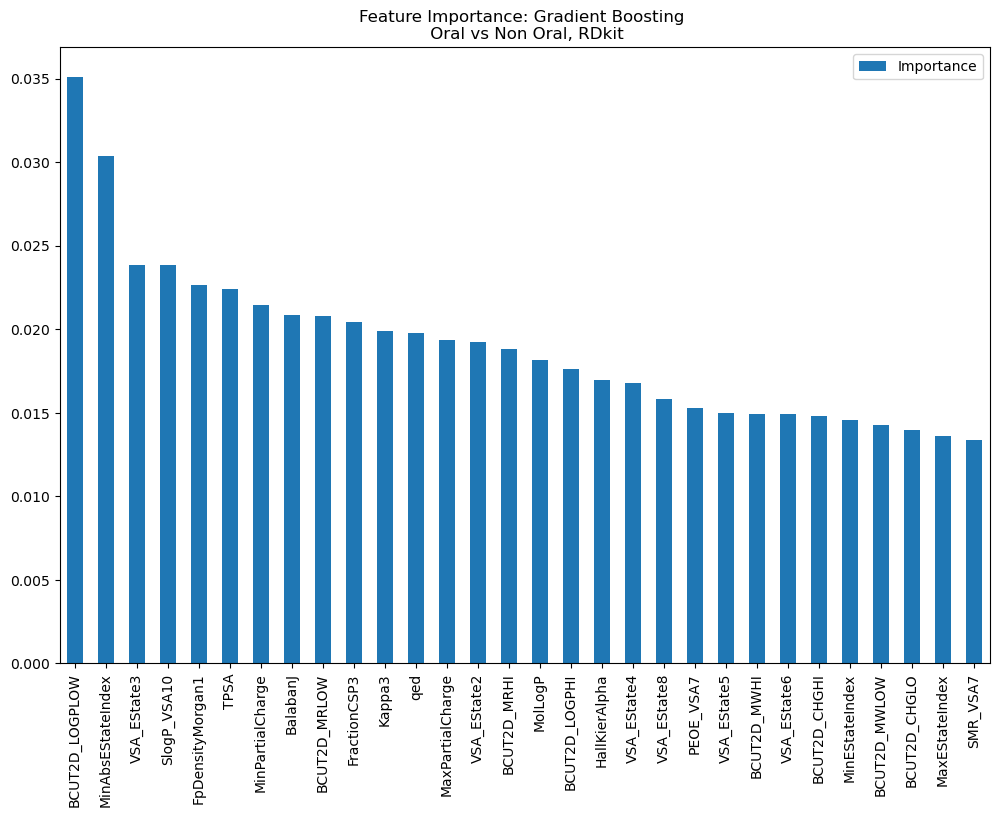

In [74]:
fig, ax = plt.subplots(1, 1)
feat_importances = pd.DataFrame(boosting.feature_importances_, 
                                index=x_train_scaled.columns, columns=['Importance'])
feat_importances.sort_values(by="Importance", ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance: Gradient Boosting \n Oral vs Non Oral, RDkit")

In [75]:
important_features_boost = feat_importances[feat_importances.Importance > 0].sort_values(by='Importance', ascending=False)
important_features_boost[0:30]


,Importance
BCUT2D_LOGPLOW,0.035108
MinAbsEStateIndex,0.030394
VSA_EState3,0.023842
SlogP_VSA10,0.023817
FpDensityMorgan1,0.022646
TPSA,0.022413
MinPartialCharge,0.021447
BalabanJ,0.020867
BCUT2D_MRLOW,0.020781
FractionCSP3,0.020435


## Saving Results

In [76]:
balanced_acc_test_boost = balanced_accuracy_score(y_test, y_predict_boost_label)
mcc_train_boost = matthews_corrcoef(y_train,boosting.predict(x_train_scaled))
mcc_test_boost = matthews_corrcoef(y_test, y_predict_boost_label)

print( f"Balanced ACC test set {balanced_acc_test_boost}, MCC test set: {mcc_test_boost}")


final_results.loc[len(final_results.index)] = [
    "Gradient Boosting",
    gs_result_boost["best_score"][0],
    mis_rate_boost_train,
    mis_rate_bost,
    auc_boost_train,
    auc_boost,
    balanced_acc_test_boost,
    mcc_train_boost,
    mcc_test_boost
]
final_results

Balanced ACC test set 0.6007369614512471, MCC test set: 0.3077565007534591


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,logistic,0.664873,0.255454,0.341772,0.702582,0.667838,0.608163,0.438663,0.237654
1,Decision Tree,0.623333,0.178747,0.371308,0.771203,0.606774,0.566043,0.627076,0.153847
2,Random Forest,0.716736,0.121745,0.308017,0.841761,0.735544,0.622449,0.749671,0.308411
3,Gradient Boosting,0.719951,0.087966,0.312236,0.883829,0.756481,0.600737,0.820038,0.307757


# SVM

Training Misclassification Rate: 0.1527
Training AUC: 0.8118
Misclassification rate: 0.2975


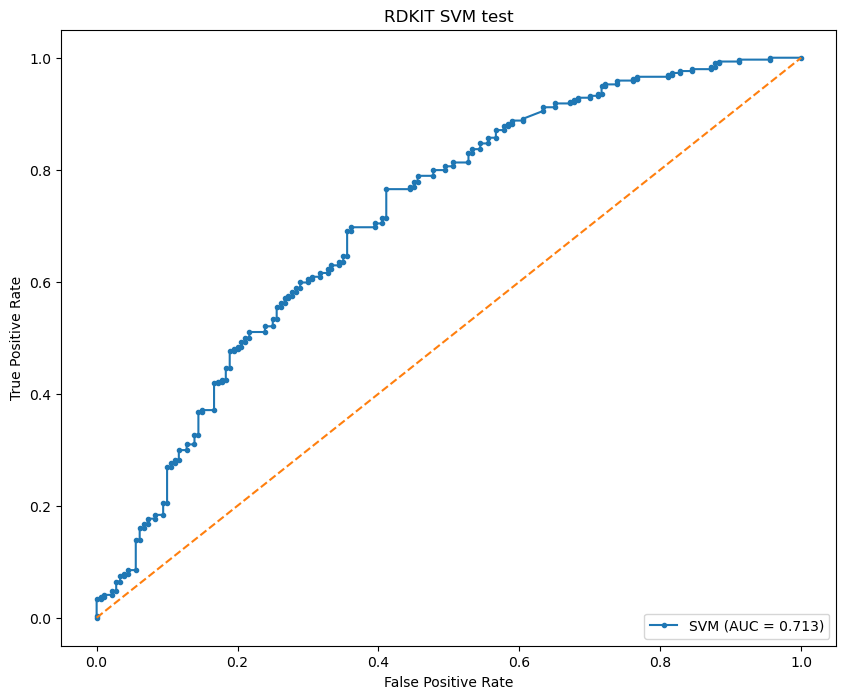

In [77]:
# Testing
svm_test_params = { 
                    'C':2, 
                    'kernel':'rbf', 
                    'gamma':'auto',
                    }
svm_test = SVC(**svm_test_params, probability=True).fit(x_train_scaled, y_train)

#make predictions
y_predict_svm_label_test = svm_test.predict(x_test_scaled)
y_predict_svm_prob_test = svm_test.predict_proba(x_test_scaled)[:,1]

mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm_test,
    x=x_train_scaled,
    y_true=y_train
)
# test error
mis_rate_svm_test, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_svm_label_test
)

auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob_test,
    model_name='SVM',
    title=f'RDKIT SVM test',
    save_path='/home/gustavo/github/mestrado/reworks/imgs/svm_test.png'
)

## Hyperparameter Fine Tuning

In [78]:
svm_model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.2, 1, 1.9, 2, 2.1],
            'kernel': ['rbf', 'sigmoid'],
            'gamma':['auto', 0.0001, 0.001, 0.01, 0.1, 0.5, 1]
        }
    }
}

In [79]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train_scaled, y_train, svm_model_params)

Starting Grid Search for SVM: 17:45
Finished Grid Search for SVM: 17:49
Tempo de execução:  3.5 minutos


## Fitting the Model

In [80]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 1.9, 'gamma': 'auto', 'kernel': 'rbf'}

In [81]:
svm = SVC(**svm_params, probability=True).fit(x_train_scaled, y_train)

## Get Training Error and AUC

In [82]:
miss_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.1569
Training AUC: 0.8065


## Make prediction

In [83]:
y_predict_svm_label = svm.predict(x_test_scaled)
y_predict_svm_prob = svm.predict_proba(x_test_scaled)[:,1]

## Test Error

In [84]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test = y_test,
    y_pred=y_predict_svm_label
)

Misclassification rate: 0.2975


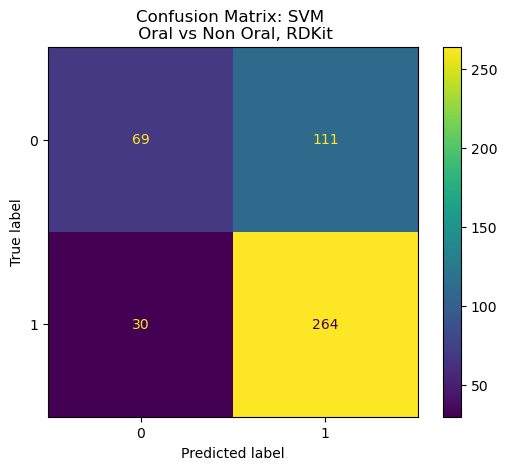

In [85]:
disp.plot()
plt.title(f"Confusion Matrix: SVM \n Oral vs Non Oral, RDKit")
plt.show()

## ROC/AUC

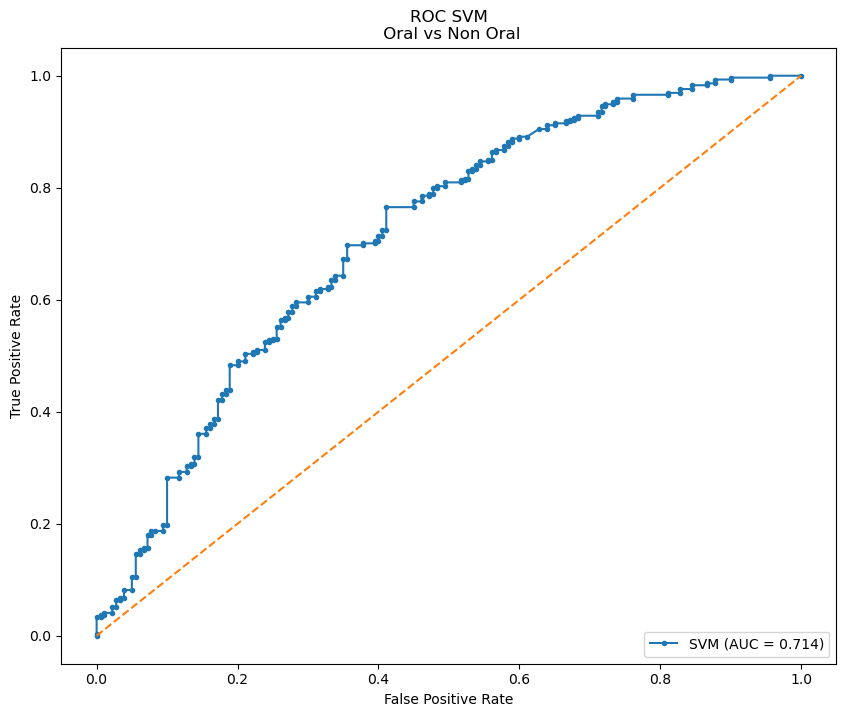

In [86]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name='SVM',
    title=f'ROC SVM\n Oral vs Non Oral',
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/roc_auc_rdkit_svm.png"
)

## Saving Results

In [87]:
balanced_acc_test_svm = balanced_accuracy_score(y_test, y_predict_svm_label)
mcc_train_svm = matthews_corrcoef(y_train, svm.predict(x_train_scaled))
mcc_test_svm = matthews_corrcoef(y_test, y_predict_svm_label)

print( f"Balanced ACC test set {balanced_acc_test_svm},MCC train set:{mcc_train_svm} MCC test set: {mcc_test_svm}")


final_results.loc[len(final_results.index)] = [
    "SVM",
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm,
    balanced_acc_test_svm,
    mcc_train_svm,
    mcc_test_svm
]
final_results

Balanced ACC test set 0.6406462585034014,MCC train set:0.6658783719024807 MCC test set: 0.33584189033540923


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,logistic,0.664873,0.255454,0.341772,0.702582,0.667838,0.608163,0.438663,0.237654
1,Decision Tree,0.623333,0.178747,0.371308,0.771203,0.606774,0.566043,0.627076,0.153847
2,Random Forest,0.716736,0.121745,0.308017,0.841761,0.735544,0.622449,0.749671,0.308411
3,Gradient Boosting,0.719951,0.087966,0.312236,0.883829,0.756481,0.600737,0.820038,0.307757
4,SVM,0.698786,0.152709,0.297468,0.806549,0.713587,0.640646,0.665878,0.335842
